In [ ]:
#!pip install flaml

In [ ]:
#!pip install ucimlrepo

In [23]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import statistics
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from ucimlrepo import fetch_ucirepo
from sklearn.utils import class_weight
from functools import partial
import warnings

warnings.filterwarnings('ignore')


In [24]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [25]:
import train_tabular_utils as tt
import cv_split_utils
import enums
import data_utils

In [26]:
class Config:
    RUN_MODE = "LOCAL"
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    TARGET_COL_NAME = "Target"        
    SCALER = enums.Scaler.StandardScaler
    METRIC = enums.Metrics.ACCURACY
    # These values are more dynamic   
    MODEL_TYPE = enums.ModelName.LGBM
    NUM_TUNING_TRIALS = 25
    TUNE_ON_SINGLE_FOLD = True
    TRAIN_SINGLE_FOLD = False    
    PERSIST_MODEL = False
    USE_OPENFE_FEATURES = True
    CREATE_MANUAL_FEATURES = False
    USE_ORIGINAL_DATA = True
    NUM_CLASSES = 3
    FEATURE_SELECTION_METHOD = "backward"

COLS_TO_LEAVE = ["id", "Target", "kfold"]
CPU_COUNT = os.cpu_count()

DATA_READPATH = "./data/"
DATA_WRITEPATH = "./output/"
SUBMISSION_FILEPATH = DATA_READPATH
if Config.RUN_MODE == "KAGGLE":    
    DATA_READPATH = "/kaggle/input/playground-series-s4e6/"
    if Config.USE_OPENFE_FEATURES:
        DATA_READPATH = "/kaggle/input/ps4e6-openfe/"
    SUBMISSION_FILEPATH = "/kaggle/input/playground-series-s4e6/"
    DATA_WRITEPATH = "/kaggle/working/"

In [27]:
# # fetch original dataset 
# predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
# df_train_orig = predict_students_dropout_and_academic_success.data.features 
# df_train_orig[Config.TARGET_COL_NAME] = predict_students_dropout_and_academic_success.data.targets[Config.TARGET_COL_NAME]
# # rename column 'Marital Status' to 'Marital status'
# df_train_orig = df_train_orig.rename(columns={'Marital Status': 'Marital status'})

In [28]:
if Config.USE_OPENFE_FEATURES and not Config.USE_ORIGINAL_DATA:
    print("using generated openfe features only on train data")
    df_train = pd.read_csv(DATA_READPATH + "train_openfe.csv")    
    df_test = pd.read_csv(DATA_READPATH + "test_openfe.csv")
elif Config.USE_OPENFE_FEATURES and Config.USE_ORIGINAL_DATA:
    print("using generated openfe features on both train and original data")
    df_train = pd.read_csv(DATA_READPATH + "train_orig_openfe.csv")    
    df_test = pd.read_csv(DATA_READPATH + "test_orig_openfe.csv")
else:    
    df_train = pd.read_csv(DATA_READPATH + "train.csv")
    df_train = df_train.drop("id", axis=1)    
    df_test = pd.read_csv(DATA_READPATH + "test.csv")
    df_test = df_test.drop("id", axis=1)
    if Config.USE_ORIGINAL_DATA:
        # add df_train_orig rows to df_train
        df_train = pd.concat([df_train, df_train_orig], axis=0, ignore_index=True)

using generated openfe features on both train and original data


In [29]:
# # Label encoding of target values
# le = LabelEncoder()
# le.fit(df_train[Config.TARGET_COL_NAME])
# df_train[Config.TARGET_COL_NAME] = le.transform(df_train[Config.TARGET_COL_NAME])
# list(le.classes_)

In [30]:
def process_col_name(cols_list):
    processed_cols_list = []
    for item in cols_list:
        # Remove round brackets but keep the text inside them
        item_no_brackets = re.sub(r'[\(\)]', '', item)
        # Remove single quotes
        item_no_quotes = item_no_brackets.replace("'", "")
        # Replace spaces with underscores
        item_processed = item_no_quotes.replace(' ', '_')
        # Append to the processed list
        processed_cols_list.append(item_processed)
    return processed_cols_list

In [31]:
train_cols_list = df_train.columns.to_list()
test_cols_list = df_test.columns.to_list()
train_processed_cols_list = process_col_name(train_cols_list)
test_processed_cols_list = process_col_name(test_cols_list)
df_train.columns = train_processed_cols_list
df_test.columns = test_processed_cols_list

In [32]:
na_val = df_train.isna().sum()
null_features = na_val.loc[na_val > 0].index.values.tolist()

In [33]:
cat_features = ['Marital_status', 'Application_mode', 'Course', 'Daytime/evening_attendance', 'Previous_qualification',
    'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Displaced',
    'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date','Gender', 'Scholarship_holder', 'International']

In [34]:
cont_features = [x for x in df_train.dtypes[df_train.dtypes == "float"].index.values if x not in null_features]
int_features = [x for x in df_train.dtypes[df_train.dtypes == "int"].index.values if x not in COLS_TO_LEAVE+null_features]
feature_cols_after_fe = [x for x in df_train.columns if x not in COLS_TO_LEAVE+null_features]

In [35]:
# for categorical features find the categories to be used for one hot encoding
int_feature_categories = []
for int_feature in int_features:
    int_feature_categories.append(sorted(df_train[int_feature].unique()))

In [36]:
print(f"len(feature_cols_after_fe)={len(feature_cols_after_fe)}")
print(feature_cols_after_fe)

len(feature_cols_after_fe)=68
['Marital_status', 'Application_mode', 'Application_order', 'Course', 'Daytime/evening_attendance', 'Previous_qualification', 'Previous_qualification_grade', 'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Admission_grade', 'Displaced', 'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'Age_at_enrollment', 'International', 'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_credited', 'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade', 'Curricular_units_2nd_sem_without_evaluations', 'Unemployment_rate', 'Inflation_rate', 'GDP', 'autoFE_f_0', 'autoFE_f

In [37]:
X_train = df_train[feature_cols_after_fe]
y_train = df_train[Config.TARGET_COL_NAME]
X_test = df_test[feature_cols_after_fe]

In [38]:
from flaml import AutoML
from sklearn.linear_model import LogisticRegression

settings = {
    "time_budget": 500,  # total running time in seconds
    "metric": "accuracy",  # primary metrics for regression can be chosen from: ['mae','mse','r2']    
    "task": "classification",  # task type
    "log_file_name": "ps4e6_flaml_experiment.log",  # flaml log file
    "seed": Config.RANDOM_SEED,  # random seed
    "ensemble": {
        "final_estimator": LogisticRegression(),
        "passthrough": False,
    },
    "max_iter": 2,
    "estimator_list": ["xgboost"],
}
automl = AutoML()
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl.logger: 06-18 18:37:20] {1680} INFO - task = classification
[flaml.automl.logger: 06-18 18:37:20] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 06-18 18:37:20] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 06-18 18:37:20] {1901} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 06-18 18:37:20] {2219} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 06-18 18:37:21] {2345} INFO - Estimated sufficient time budget=72380s. Estimated necessary time budget=72s.
[flaml.automl.logger: 06-18 18:37:21] {2392} INFO -  at 2.2s,	estimator xgboost's best error=0.2114,	best estimator xgboost's best error=0.2114
[flaml.automl.logger: 06-18 18:37:21] {2219} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 06-18 18:37:22] {2392} INFO -  at 3.2s,	estimator xgboost's best error=0.2114,	best estimator xgboost's best error=0.2114
[flaml.automl.logger: 06-18 18:37:22] {2526} INFO - [('xgboost',

In [39]:
print(automl.best_config_per_estimator)

{'xgboost': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 0.9999999999999993, 'learning_rate': 0.09999999999999995, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}}


In [ ]:
print(automl.best_loss_per_estimator)

In [40]:
print("Best estimator: ", automl.best_estimator)
print("Best hyperparmeter config:", automl.best_config)
print("Best accuracy on validation data: {0:.6g}".format(1 - automl.best_loss))
print("Training duration of best run: {0:.4g} s".format(automl.best_config_train_time))
print("Best iteration: ", automl.best_iteration)
print("Best loss: ", automl.best_loss)

Best estimator:  xgboost
Best hyperparmeter config: {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 0.9999999999999993, 'learning_rate': 0.09999999999999995, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}
Best accuracy on validation data: 0.788564
Training duration of best run: 0.832 s


In [41]:
df_feature_imp = pd.DataFrame()
df_feature_imp["f_name"] = automl.feature_names_in_
df_feature_imp["f_imp"] = automl.feature_importances_
df_feature_imp = df_feature_imp.sort_values(by="f_imp", ascending=False)

In [50]:
def plot_feature_importance(df_feature_imp, fig_size=(18, 6)):
    # Set the figure size
    plt.figure(figsize=(18, 6))
    # Create the bar plot
    sns.barplot(x="f_name", y="f_imp", data=df_feature_imp)
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)
    # Add feature importance values on top of each bar (adjusted positioning)
    for bar in plt.gca().containers[0]:
      plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.04, round(bar.get_height(), 3), 
           ha='center', va='center', rotation=90)  # Adjust vertical offset
    # Customize plot title and labels (optional)
    plt.title("Feature Importance")
    plt.xlabel("Feature Name")
    plt.ylabel("Feature Importance")
    # Show the plot
    plt.show()

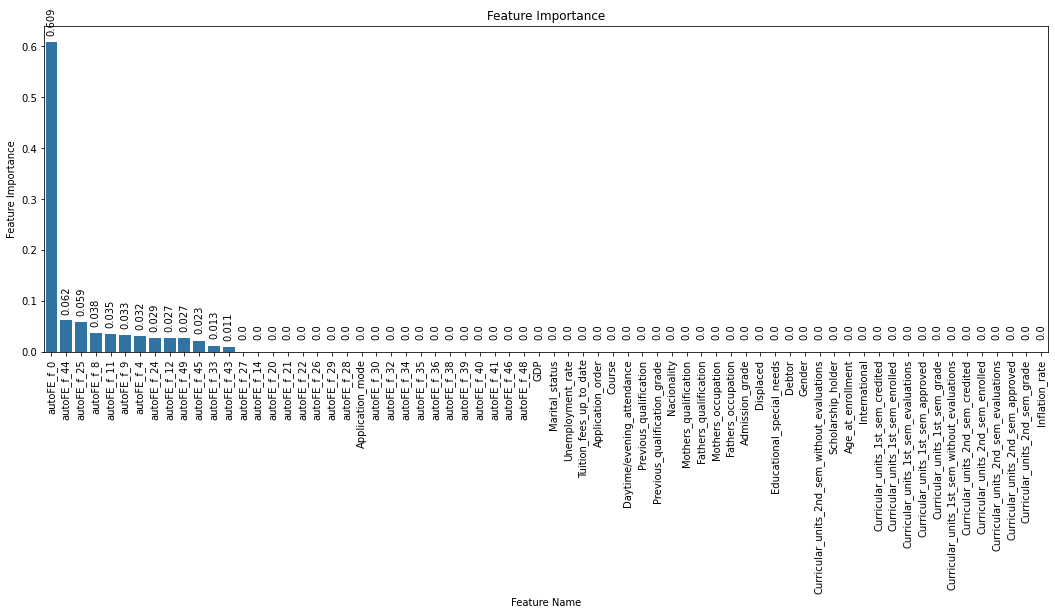

In [51]:
plot_feature_importance(df_feature_imp)

In [42]:
test_preds = automl.predict(X_test)
test_preds[:5]

array(['Dropout', 'Graduate', 'Graduate', 'Graduate', 'Enrolled'],
      dtype=object)

In [43]:
df_submission1 = pd.read_csv(SUBMISSION_FILEPATH + 'sample_submission.csv')
df_submission1[Config.TARGET_COL_NAME] = test_preds
df_submission1.to_csv(DATA_WRITEPATH + f'submission_flaml.csv',index=False)
df_submission1.head()

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled
